In [67]:
import pandas as pd

df_results = pd.read_csv("../data/results.csv")
df_drivers = pd.read_csv("../data/drivers.csv")
df_constructors = pd.read_csv("../data/constructors.csv")
df_races = pd.read_csv("../data/races.csv")

In [68]:
df = df_results.merge(df_drivers, on='driverId', how='left', suffixes=('', '_driver'))

In [69]:
df = df.merge(df_constructors, on='constructorId', how='left', suffixes=('', '_constructor'))

In [70]:
df = df.merge(df_races, on='raceId', how='left', suffixes=('', '_race'))

In [71]:
print(df.columns)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverRef', 'number_driver', 'code',
       'forename', 'surname', 'dob', 'nationality', 'url', 'constructorRef',
       'name', 'nationality_constructor', 'url_constructor', 'year', 'round',
       'circuitId', 'name_race', 'date', 'time_race', 'url_race', 'fp1_date',
       'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')


In [72]:
df['name_driver'] = df['forename'] + ' ' + df['surname']

df_basic = df[[
    'raceId',
    'year',
    'round',
    'driverId',
    'constructorId',
    'grid',
    'positionOrder',
    'points',
    'name_driver',
    'name',
    'circuitId'
]].copy()

In [73]:
df_basic = df_basic[df_basic['positionOrder'].notna()]

In [74]:
#last 5 races performance

df_basic.sort_values(by=['driverId', 'year', 'round'])

df_basic['driver_avg_finish_last_5'] = (
    df_basic.groupby('driverId')['positionOrder']
            .rolling(window=5, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
)

df_basic['driver_points_last_5'] = (
    df_basic.groupby('driverId')['points']
            .rolling(window=5, min_periods=1)
            .sum()
            .reset_index(level=0, drop=True)
)

df_basic['driver_avg_finish_last_5'] = df_basic['driver_avg_finish_last_5'].fillna(
    df_basic['driver_avg_finish_last_5'].mean()
)
df_basic['driver_points_last_5'] = df_basic['driver_points_last_5'].fillna(0)

In [75]:
#teammate performance comparison

df_teammate = df_basic[['raceId','constructorId','driverId','grid','positionOrder','points']]

df_basic = df_basic.merge(
    df_teammate,
    on=['raceId','constructorId'],
    suffixes=('', '_teammate')
)

df_basic = df_basic[df_basic['driverId'] != df_basic['driverId_teammate']]

df_basic['grid_diff_teammate'] = df_basic['grid'] - df_basic['grid_teammate']
df_basic['finish_diff_teammate'] = df_basic['positionOrder'] - df_basic['positionOrder_teammate']
df_basic['points_diff_teammate'] = df_basic['points'] - df_basic['points_teammate']

df_basic = df_basic.drop(columns=['driverId_teammate','grid_teammate','positionOrder_teammate','points_teammate'])


In [76]:
from sklearn.preprocessing import LabelEncoder

le_driver = LabelEncoder()
le_constructor = LabelEncoder()
le_circuit = LabelEncoder()

df_basic['driver_encoded'] = le_driver.fit_transform(df_basic['driverId'])
df_basic['constructor_encoded'] = le_constructor.fit_transform(df_basic['constructorId'])
df_basic['circuit_encoded'] = le_circuit.fit_transform(df_basic['circuitId'])

In [79]:
features = df_basic[[
    'year',
    'round',
    'grid',
    'driver_encoded',
    'constructor_encoded',
    'circuit_encoded',
    'driver_avg_finish_last_5',
    'driver_points_last_5',
    'grid_diff_teammate',
    'finish_diff_teammate',
    'points_diff_teammate'
]]

target = df_basic['positionOrder']

X = features
y = target

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

In [ ]:
#random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Baseline Random Forest Performance:")
print(f"MAE (mean absolute error): {mae:.2f}")
print(f"RMSE (root mean squared error): {rmse:.2f}")
print(f"R^2 score: {r2:.2f}")

Baseline Random Forest Performance:
MAE (mean absolute error): 4.80
RMSE (root mean squared error): 6.01
R^2 score: 0.39


In [81]:
#XGBoost regressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

XGBoost Performance:
MAE: 1.63
RMSE: 2.41
R^2: 0.91


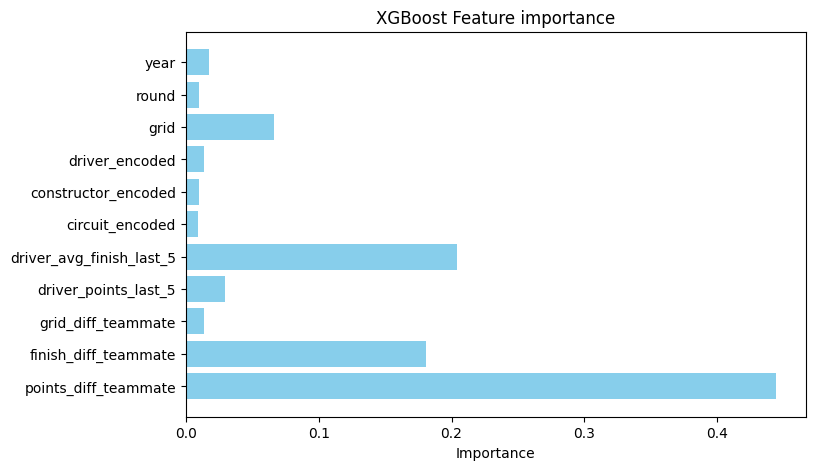

In [83]:
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_

feature_names = ['year', 'round', 'grid', 'driver_encoded', 'constructor_encoded', 'circuit_encoded', 'driver_avg_finish_last_5', 'driver_points_last_5','grid_diff_teammate', 'finish_diff_teammate', 'points_diff_teammate' ]

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("XGBoost Feature importance")
plt.gca().invert_yaxis()
plt.show()